In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import os
os.chdir("..")
plt.style.use('plot_style.txt')
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes',prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
from matplotlib import cm
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns

In [2]:
s1=5.1667 / 1.0
s2=5.1667 / 1.5
a_scale =100

In [3]:
marker_list = ['^','<','>','v','*','o','+','1','2']

In [4]:
fig_save_path = os.path.join(os.path.abspath(os.curdir), "Simulation", 'figures')

In [5]:
print(fig_save_path)

/Users/sophiezhu/Documents/Code/CN530/Simulation/figures


In [21]:
import VPSModeling.Network as net

In [7]:
import pickle
y_scale=100

In [8]:
A = 1
B = 115
C=20
this_amp_exc=2/B 
this_amp_inh=1/C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = [0.003,0.002,0.001,0]


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]

pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()


inh_overlap_list =[]


this_sig_list =np.array([0.75,1,1.25,1.5,1.75,2])


alpha_response_list = []
this_alpha=0.003*a_scale


for v1_amp_scale in tqdm(this_sig_list):
    fig = plt.figure(figsize=(4, 3))
    
    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 * v1_amp_scale# *unit_2_scale
    
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale

    overlap = []

    for i in range(len(frequency_list)): 

        stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

        I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

        I.fill(trough)

        time_ed1 = time_st1 + stimulus_duration


        time_st2 = time_ed1 + stimulus_duration
        time_ed2 = time_st2 + stimulus_duration

        I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
        I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )

        this_X_vec = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)

        a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
        b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

        response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
        response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]

        overlap.append(net.get_2response_pdf_v(response1,response2))

    inh_overlap_list.append(overlap)







100%|██████████| 299/299 [00:00<00:00, 4887.46it/s]

100%|██████████| 299/299 [00:00<00:00, 4799.73it/s]

100%|██████████| 299/299 [00:00<00:00, 4944.20it/s]

100%|██████████| 299/299 [00:00<00:00, 4763.88it/s]

100%|██████████| 299/299 [00:00<00:00, 5261.95it/s]

100%|██████████| 299/299 [00:00<00:00, 4941.92it/s]

100%|██████████| 299/299 [00:00<00:00, 5087.14it/s]

100%|██████████| 299/299 [00:00<00:00, 4912.59it/s]

100%|██████████| 299/299 [00:00<00:00, 4959.94it/s]

100%|██████████| 299/299 [00:00<00:00, 4762.36it/s]

100%|██████████| 299/299 [00:00<00:00, 4583.59it/s]

100%|██████████| 299/299 [00:00<00:00, 4278.95it/s]

100%|██████████| 299/299 [00:00<00:00, 4623.60it/s]

100%|██████████| 299/299 [00:00<00:00, 4925.13it/s]

100%|██████████| 299/299 [00:00<00:00, 5210.23it/s]

100%|██████████| 299/299 [00:00<00:00, 5089.97it/s]

100%|██████████| 299/299 [00:00<00:00, 5173.73it/s]

100%|██████████| 299/299 [00:00<00:00, 4966.35it/s]

100%|██████████| 299/299 [00:00<00:00, 5139.05

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

# Figure 3D, 3C

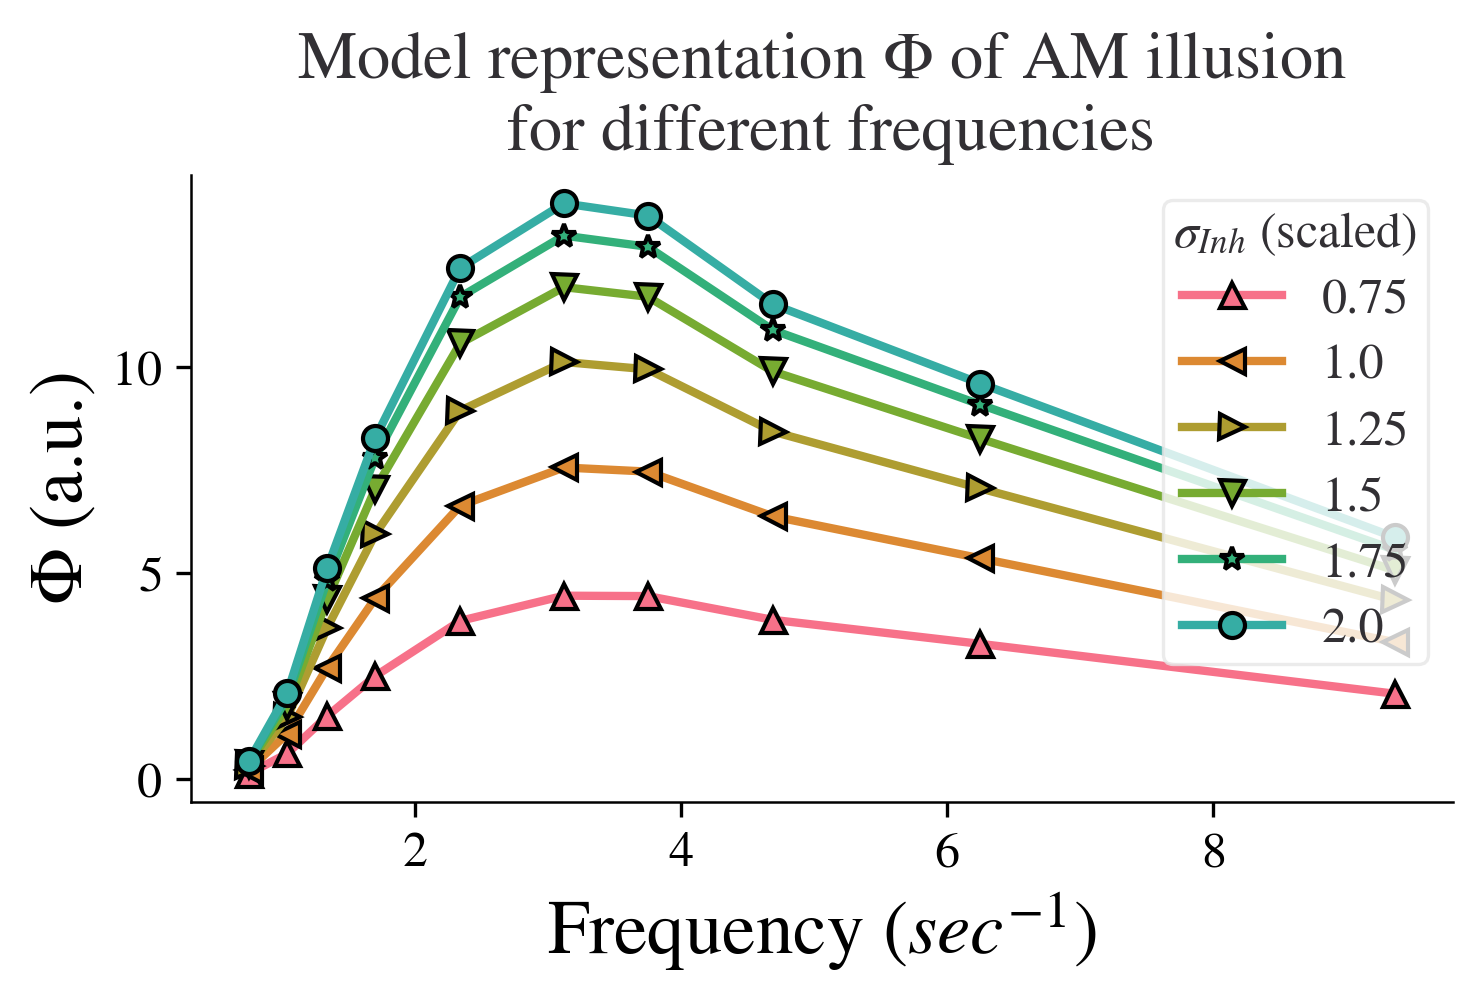

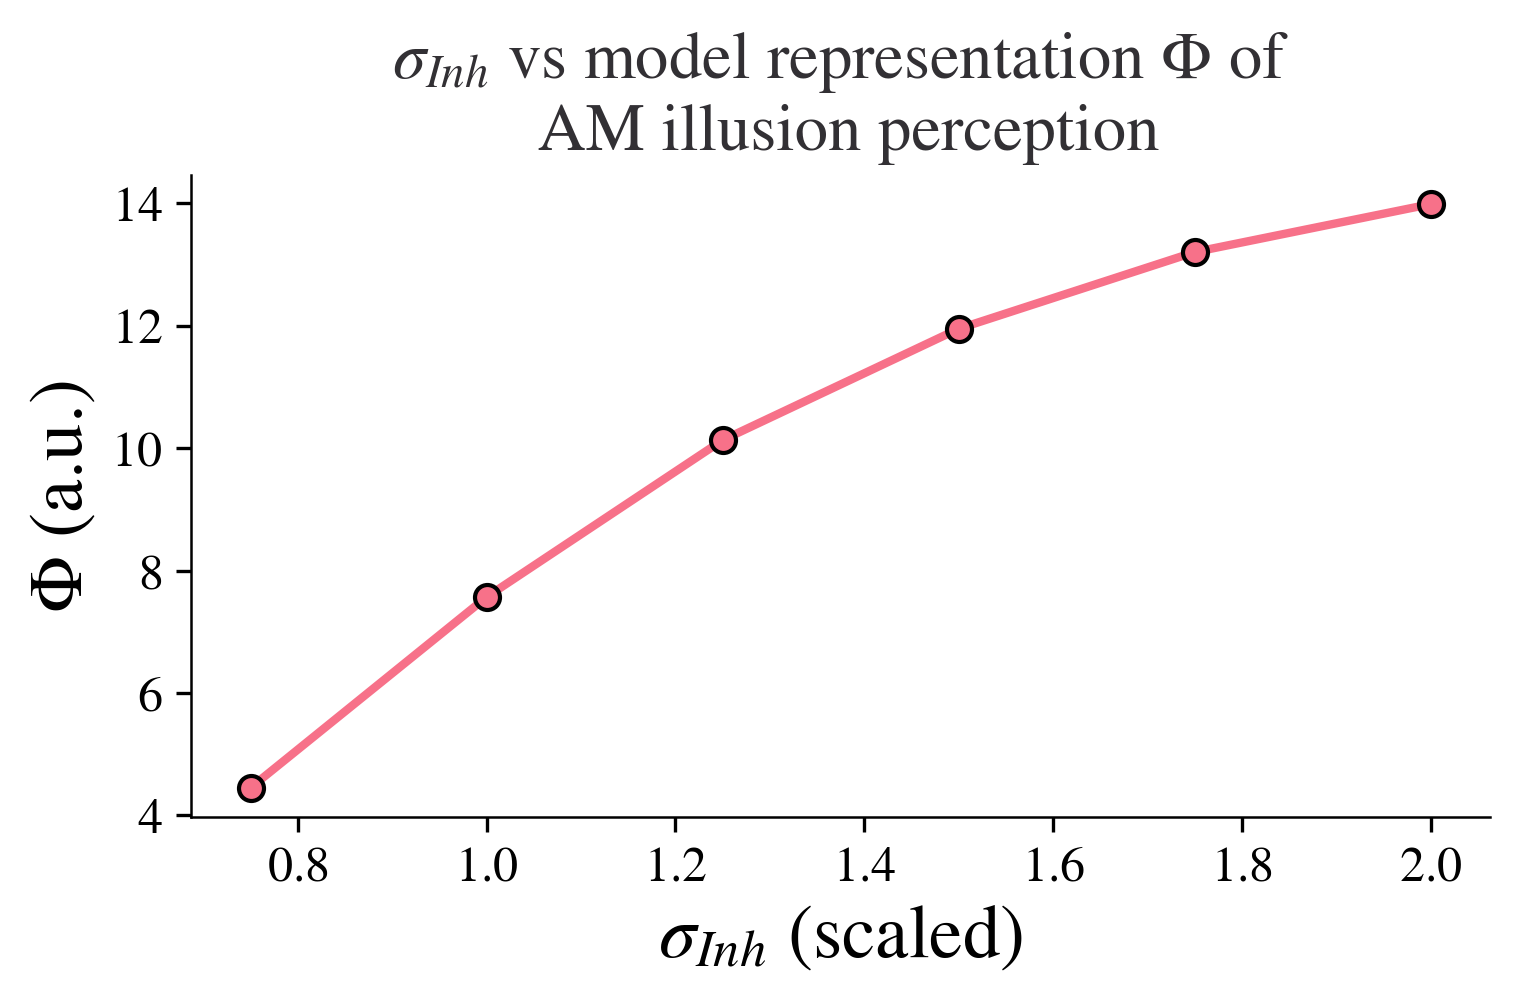

In [9]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)
plt.figure(figsize=(s1, s2))
inh_overlap_list = np.array(inh_overlap_list)
for i in range(len(this_sig_list)):
    plt.plot(frequency_list,np.squeeze(inh_overlap_list[i]),marker=marker_list[i],label=str(this_sig_list[i]))

plt.xlabel(r"Frequency $(sec^{-1})$")
plt.ylabel("$\Phi$ (a.u.)")
plt.legend(title=r'$\sigma_{Inh}$ (scaled)', loc='upper right',fontsize=12, title_fontsize=12) #,fontsize=7.5, title_fontsize=7.5 )# bbox_to_anchor=(1, 0.5))
plt.title('Model representation $\Phi$ of AM illusion \n for different frequencies', loc='center',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_inh_sig_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_inh_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    
    
plt.figure(figsize=(s1, s2))
max_overlap_list =[]
for i in range(len(inh_overlap_list)):
    max_overlap_list.append(np.max((inh_overlap_list[i])))
plt.plot(this_sig_list, np.array(max_overlap_list),marker='o')
plt.xlabel(r'$\sigma_{Inh}$ (scaled)')
plt.ylabel("$\Phi$ (a.u.)")
plt.title('$\sigma_{Inh}$ vs model representation $\Phi$ of \n AM illusion perception', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path, 'am_inh_sig_hi_plot.'+'png'),dpi=300)
with open(os.path.join(fig_save_path, 'am_inh_sig_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)




In [10]:
A = 1
B = 115
C=20
this_amp_exc= 2 /B 
this_amp_inh= 1 /C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = np.array([0.003,0.002,0.001,0])*a_scale


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]


pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()



overlap_list =[]


for this_alpha in this_alpha_list:
    overlap = []

    for i in range(len(frequency_list)): 

        stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

        I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

        I.fill(trough)

        time_ed1 = time_st1 + stimulus_duration


        time_st2 = time_ed1 + stimulus_duration
        time_ed2 = time_st2 + stimulus_duration

        I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
        I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


        v1_amp_scale =1
        v1_sigma_Ex_scale = 1 # *unit_2_scale
        v1_sigma_inh_scale =1 # *unit_2_scale
       
        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*v1_amp_scale


        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc)

        this_X_vec = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)


        a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
        b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

        response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
        response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]


        overlap.append(net.get_2response_pdf_v(response1,response2))

    overlap_list.append(overlap)




100%|██████████| 299/299 [00:00<00:00, 5201.99it/s]


# Figure 4E

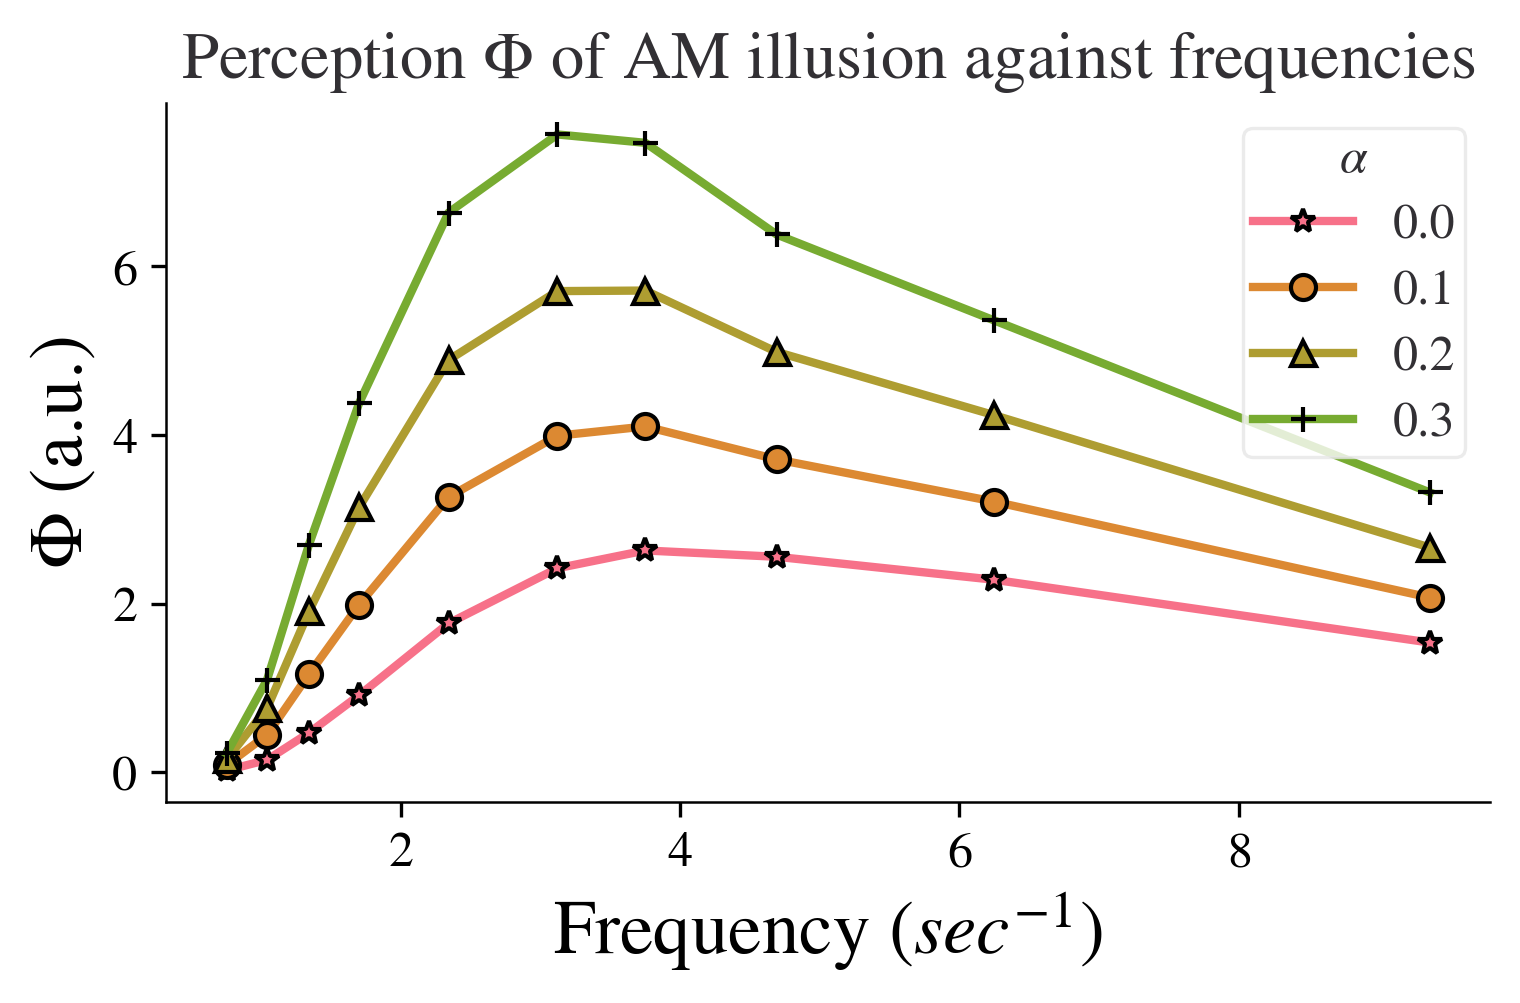

In [11]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)
plt.figure(figsize=(s1, s2))

overlap_list = np.array(overlap_list)
plt.plot(frequency_list,np.squeeze(overlap_list[3]),marker='*',label=str(this_alpha_list[-1]))
plt.plot(frequency_list,np.squeeze(overlap_list[2]),marker='o',label=str(this_alpha_list[-2]))
plt.plot(frequency_list,np.squeeze(overlap_list[1]),marker='^',label=str(this_alpha_list[-3]))
plt.plot(frequency_list,np.squeeze(overlap_list[0]),marker='+',label=str(this_alpha_list[-4]))

plt.xlabel(r'Frequency $(sec^{-1})$')
plt.ylabel("$\Phi$ (a.u.)")
plt.legend(title=r'$\alpha$',fontsize=12,title_fontsize=12)

plt.title('Perception $\Phi$ of AM illusion against frequencies', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_al_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_al_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [12]:
overlap_list

array([[0.22059864, 1.09614619, 2.69968194, 4.3820002 , 6.63910265,
        7.56678993, 7.46753064, 6.37950466, 5.35889005, 3.31830792],
       [0.14984642, 0.75927796, 1.90581805, 3.14468234, 4.88978865,
        5.70775549, 5.71404832, 4.98586159, 4.23459797, 2.66463   ],
       [0.08302107, 0.44206877, 1.16088807, 1.98782711, 3.2647609 ,
        3.991455  , 4.10112956, 3.71075663, 3.20875877, 2.07059802],
       [0.02012843, 0.14455646, 0.46502712, 0.91172554, 1.7645973 ,
        2.4185972 , 2.62945738, 2.55470283, 2.28175353, 1.5363864 ]])

# Figure 4D

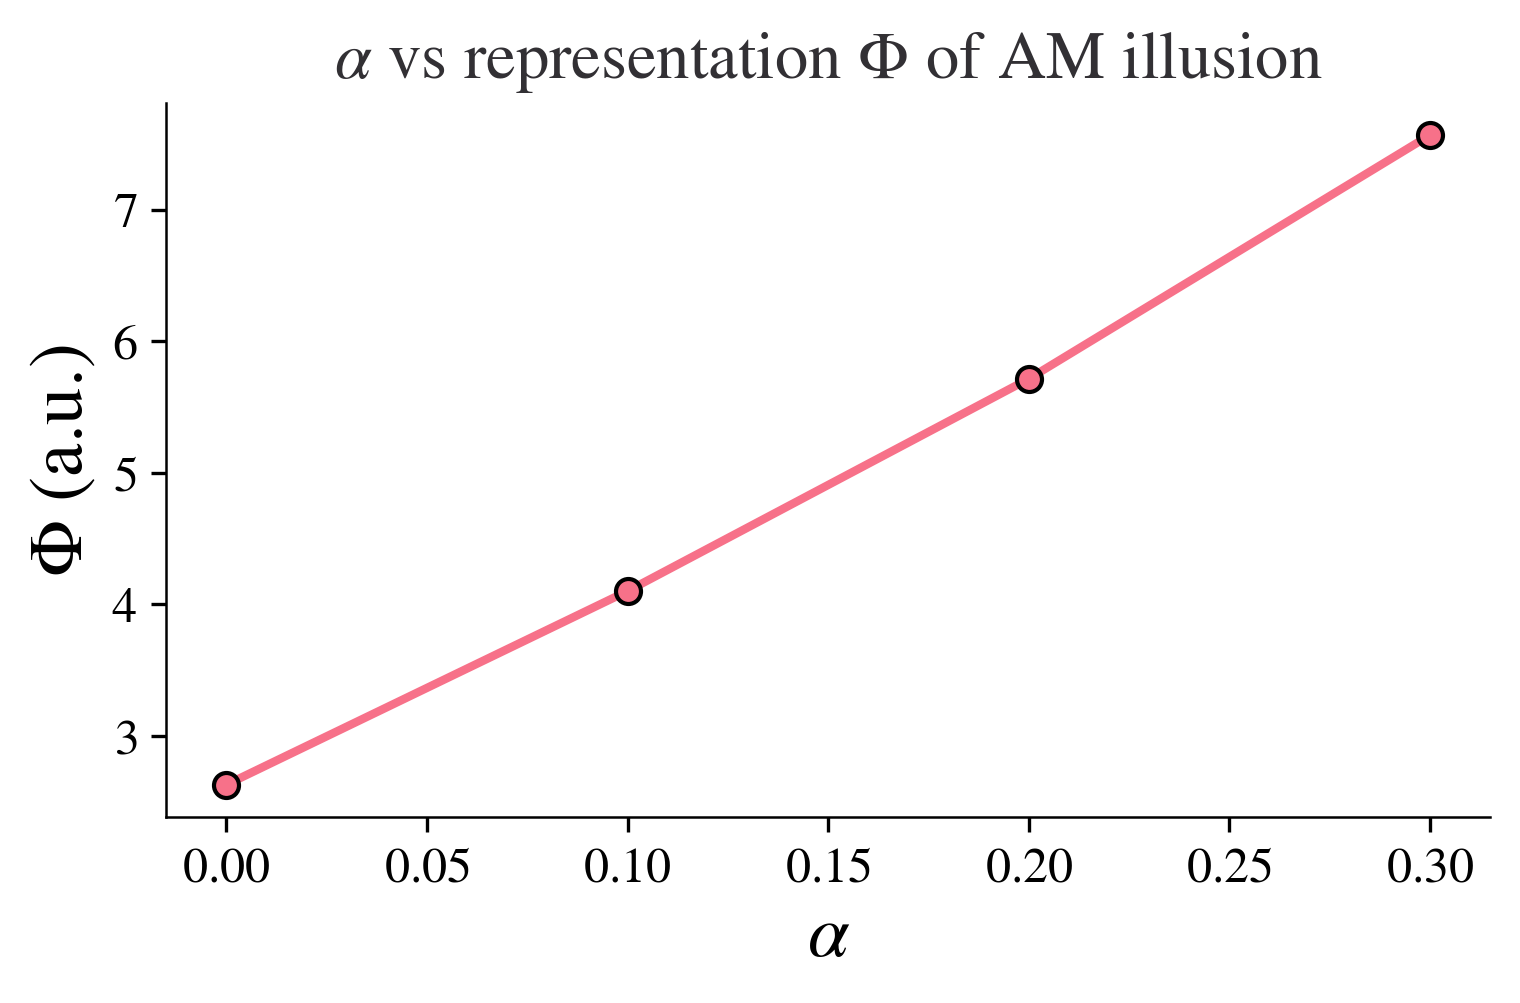

In [13]:
plt.figure(figsize=(s1, s2))
max_overlap_list =[]
for i in range(len(overlap_list)):
    max_overlap_list.append(np.max((overlap_list[i])))
plt.plot(this_alpha_list, np.array(max_overlap_list),marker='o')

#plt.xticks(np.arange(len(frequency_list)), frequency_list)
plt.xlabel(r"$\alpha$")
plt.ylabel("$\Phi$ (a.u.)")
#plt.legend(title=r'$\alpha$')
plt.title(r'$\alpha$ vs representation $\Phi$ of AM illusion', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_al_hi_plot.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_al_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [14]:
this_alpha_list

array([0.3, 0.2, 0.1, 0. ])

100%|██████████| 299/299 [00:00<00:00, 5281.94it/s]

100%|██████████| 299/299 [00:00<00:00, 5071.75it/s]

100%|██████████| 299/299 [00:00<00:00, 5297.94it/s]

100%|██████████| 299/299 [00:00<00:00, 5107.71it/s]

100%|██████████| 299/299 [00:00<00:00, 5425.40it/s]

100%|██████████| 299/299 [00:00<00:00, 5108.57it/s]

100%|██████████| 299/299 [00:00<00:00, 5287.18it/s]

100%|██████████| 299/299 [00:00<00:00, 4889.76it/s]

100%|██████████| 299/299 [00:00<00:00, 5285.28it/s]

100%|██████████| 299/299 [00:00<00:00, 5038.68it/s]

100%|██████████| 299/299 [00:00<00:00, 5273.57it/s]

100%|██████████| 299/299 [00:00<00:00, 5127.68it/s]

100%|██████████| 299/299 [00:00<00:00, 5391.30it/s]

100%|██████████| 299/299 [00:00<00:00, 4983.60it/s]

100%|██████████| 299/299 [00:00<00:00, 5152.69it/s]

100%|██████████| 299/299 [00:00<00:00, 5081.84it/s]

100%|██████████| 299/299 [00:00<00:00, 5391.21it/s]

100%|██████████| 299/299 [00:00<00:00, 5100.11it/s]

100%|██████████| 299/299 [00:00<00:00, 5257.03

100%|██████████| 299/299 [00:00<00:00, 5293.45it/s]

100%|██████████| 299/299 [00:00<00:00, 4723.60it/s]

100%|██████████| 299/299 [00:00<00:00, 4873.50it/s]

100%|██████████| 299/299 [00:00<00:00, 4970.56it/s]

100%|██████████| 299/299 [00:00<00:00, 5265.00it/s]

100%|██████████| 299/299 [00:00<00:00, 5065.91it/s]

100%|██████████| 299/299 [00:00<00:00, 5211.07it/s]

100%|██████████| 299/299 [00:00<00:00, 5110.94it/s]

100%|██████████| 299/299 [00:00<00:00, 5445.97it/s]

100%|██████████| 299/299 [00:00<00:00, 5136.31it/s]

100%|██████████| 299/299 [00:00<00:00, 5226.82it/s]

100%|██████████| 299/299 [00:00<00:00, 4890.58it/s]

100%|██████████| 299/299 [00:00<00:00, 5265.47it/s]

100%|██████████| 299/299 [00:00<00:00, 4911.86it/s]

100%|██████████| 299/299 [00:00<00:00, 5016.89it/s]

100%|██████████| 299/299 [00:00<00:00, 4988.10it/s]

100%|██████████| 299/299 [00:00<00:00, 5389.33it/s]

100%|██████████| 299/299 [00:00<00:00, 5100.63it/s]

100%|██████████| 299/299 [00:00<00:00, 5294.21

100%|██████████| 299/299 [00:00<00:00, 5240.93it/s]

100%|██████████| 299/299 [00:00<00:00, 5111.29it/s]

100%|██████████| 299/299 [00:00<00:00, 5309.04it/s]

100%|██████████| 299/299 [00:00<00:00, 5067.77it/s]

100%|██████████| 299/299 [00:00<00:00, 5335.08it/s]

100%|██████████| 299/299 [00:00<00:00, 5071.89it/s]

100%|██████████| 299/299 [00:00<00:00, 5231.66it/s]

100%|██████████| 299/299 [00:00<00:00, 5091.19it/s]

100%|██████████| 299/299 [00:00<00:00, 5089.78it/s]

100%|██████████| 299/299 [00:00<00:00, 4714.88it/s]

100%|██████████| 299/299 [00:00<00:00, 5057.84it/s]

100%|██████████| 299/299 [00:00<00:00, 4851.29it/s]

100%|██████████| 299/299 [00:00<00:00, 5231.57it/s]

100%|██████████| 299/299 [00:00<00:00, 5082.38it/s]

100%|██████████| 299/299 [00:00<00:00, 5283.90it/s]

100%|██████████| 299/299 [00:00<00:00, 5120.06it/s]

100%|██████████| 299/299 [00:00<00:00, 5438.03it/s]

100%|██████████| 299/299 [00:00<00:00, 5026.54it/s]

100%|██████████| 299/299 [00:00<00:00, 5158.81

100%|██████████| 299/299 [00:00<00:00, 4995.39it/s]

100%|██████████| 299/299 [00:00<00:00, 5201.17it/s]

100%|██████████| 299/299 [00:00<00:00, 5075.55it/s]

100%|██████████| 299/299 [00:00<00:00, 5310.08it/s]

100%|██████████| 299/299 [00:00<00:00, 5045.75it/s]

100%|██████████| 299/299 [00:00<00:00, 5252.98it/s]

100%|██████████| 299/299 [00:00<00:00, 5090.73it/s]

100%|██████████| 299/299 [00:00<00:00, 5416.40it/s]

100%|██████████| 299/299 [00:00<00:00, 5081.84it/s]

100%|██████████| 299/299 [00:00<00:00, 5285.28it/s]

100%|██████████| 299/299 [00:00<00:00, 5062.31it/s]

100%|██████████| 299/299 [00:00<00:00, 5403.75it/s]

100%|██████████| 299/299 [00:00<00:00, 5106.11it/s]

100%|██████████| 299/299 [00:00<00:00, 5057.25it/s]

100%|██████████| 299/299 [00:00<00:00, 4926.10it/s]

100%|██████████| 299/299 [00:00<00:00, 5142.21it/s]

100%|██████████| 299/299 [00:00<00:00, 4852.56it/s]

100%|██████████| 299/299 [00:00<00:00, 4676.26it/s]

100%|██████████| 299/299 [00:00<00:00, 4932.28

100%|██████████| 299/299 [00:00<00:00, 4859.09it/s]

100%|██████████| 299/299 [00:00<00:00, 5047.42it/s]

100%|██████████| 299/299 [00:00<00:00, 4910.09it/s]

100%|██████████| 299/299 [00:00<00:00, 5190.33it/s]

100%|██████████| 299/299 [00:00<00:00, 4911.79it/s]

100%|██████████| 299/299 [00:00<00:00, 5065.91it/s]

100%|██████████| 299/299 [00:00<00:00, 4909.44it/s]

100%|██████████| 299/299 [00:00<00:00, 5166.93it/s]

100%|██████████| 299/299 [00:00<00:00, 4935.93it/s]

100%|██████████| 299/299 [00:00<00:00, 5074.52it/s]

100%|██████████| 299/299 [00:00<00:00, 4933.43it/s]

100%|██████████| 299/299 [00:00<00:00, 5144.51it/s]

100%|██████████| 299/299 [00:00<00:00, 4930.11it/s]

100%|██████████| 299/299 [00:00<00:00, 5032.67it/s]

100%|██████████| 299/299 [00:00<00:00, 4903.16it/s]

100%|██████████| 299/299 [00:00<00:00, 5178.11it/s]

100%|██████████| 299/299 [00:00<00:00, 4913.17it/s]

100%|██████████| 299/299 [00:00<00:00, 5067.20it/s]

100%|██████████| 299/299 [00:00<00:00, 4929.03

<Figure size 1200x900 with 0 Axes>

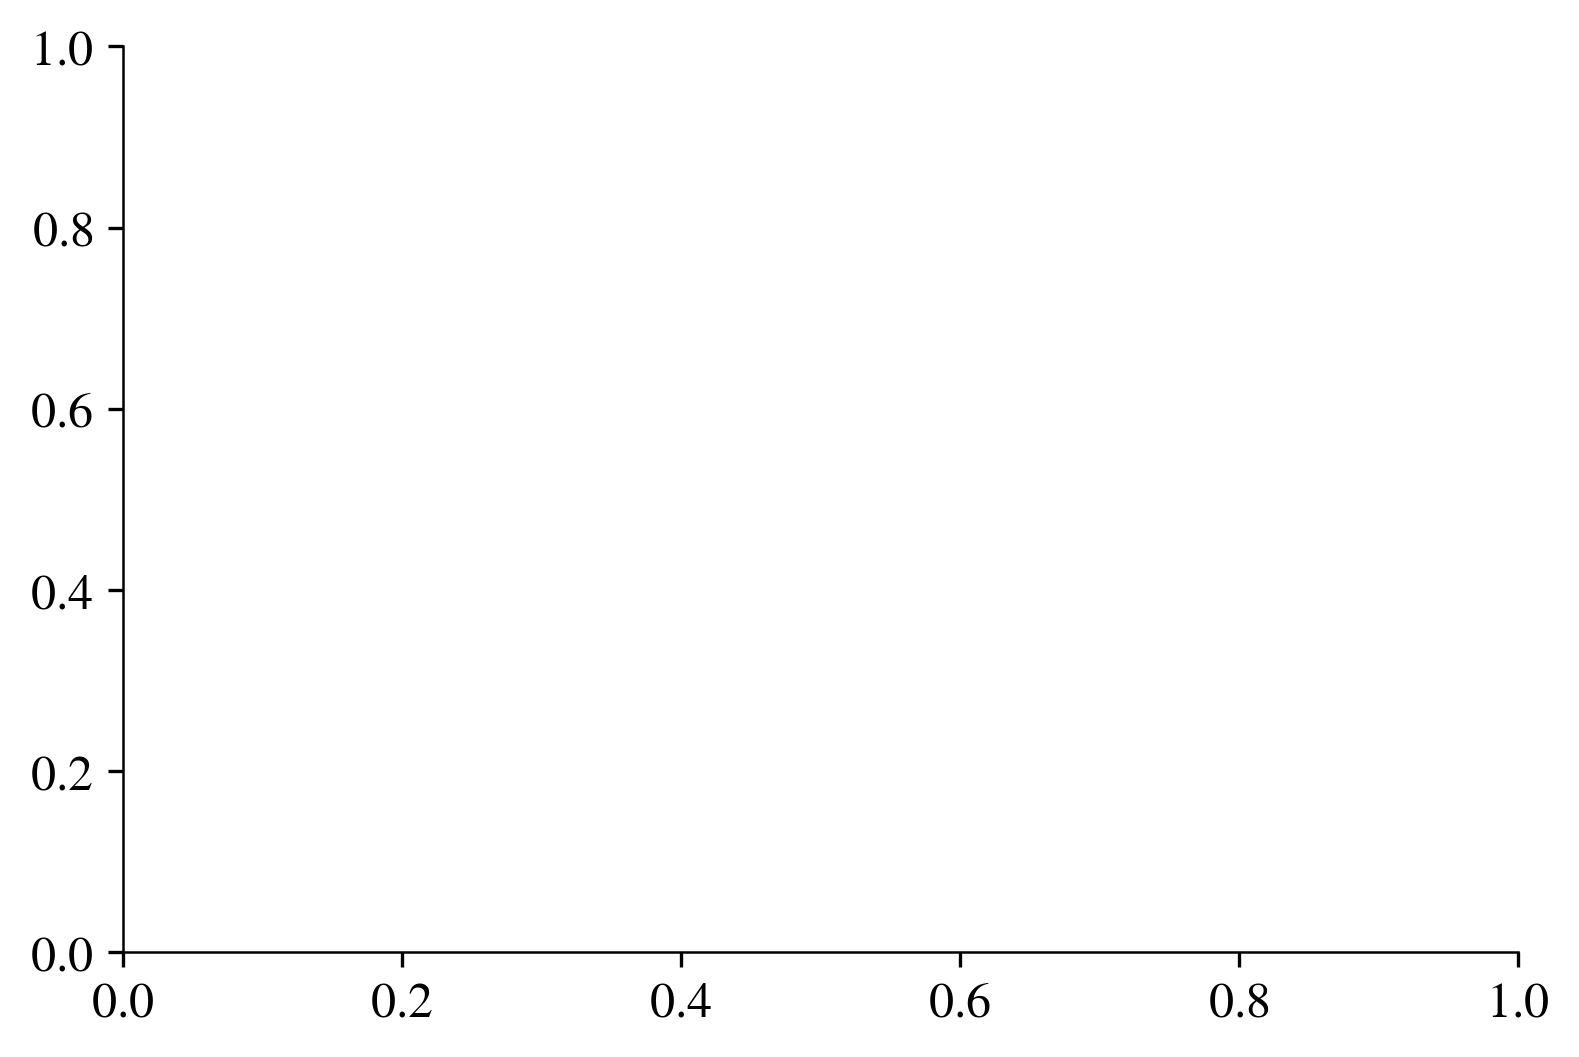

In [15]:
A = 1
B = 115
C=20
this_amp_exc= 2 /B #* 0.1 # h=0.46
this_amp_inh= 1 /C #* 5.75*0.1 # h=0.23

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

this_alpha_list
timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size



plt.figure(figsize=(4, 3))

this_alpha_list = np.array([0.003,0.002,0.001,0])*a_scale

fig, axes = plt.subplots()
linestyles=['solid','-.']


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]


pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()



inh_overlap_list =[]

this_amp_list =[0.25,0.5,0.75,1,1.25,1.5,1.75,2]


alpha_response_list = []
this_alpha=0.003*a_scale

inh_and_alpha_overlap_list = []

for v1_inh_scale in this_amp_list:

    v1_sigma_Ex_scale = 1 
    v1_sigma_inh_scale =1 * v1_inh_scale 
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale


    alpha_response_list = []

    for this_alpha in tqdm(this_alpha_list):
        overlap = []

        for i in range(len(frequency_list)): 

            stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

            I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

            I.fill(trough)

            time_ed1 = time_st1 + stimulus_duration


            time_st2 = time_ed1 + stimulus_duration
            time_ed2 = time_st2 + stimulus_duration

            I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
            I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


            X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc)

            this_X_vec = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
            this_X_vec_V1 = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
            this_X_vec_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
            this_X_vec_V1_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)


            a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
            b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

            response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
            response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]
            
            overlap.append(net.get_2response_pdf_v(response1,response2))

        inh_and_alpha_overlap_list.append(overlap)









# Figure 4F

1
2
3
4
5
6
7


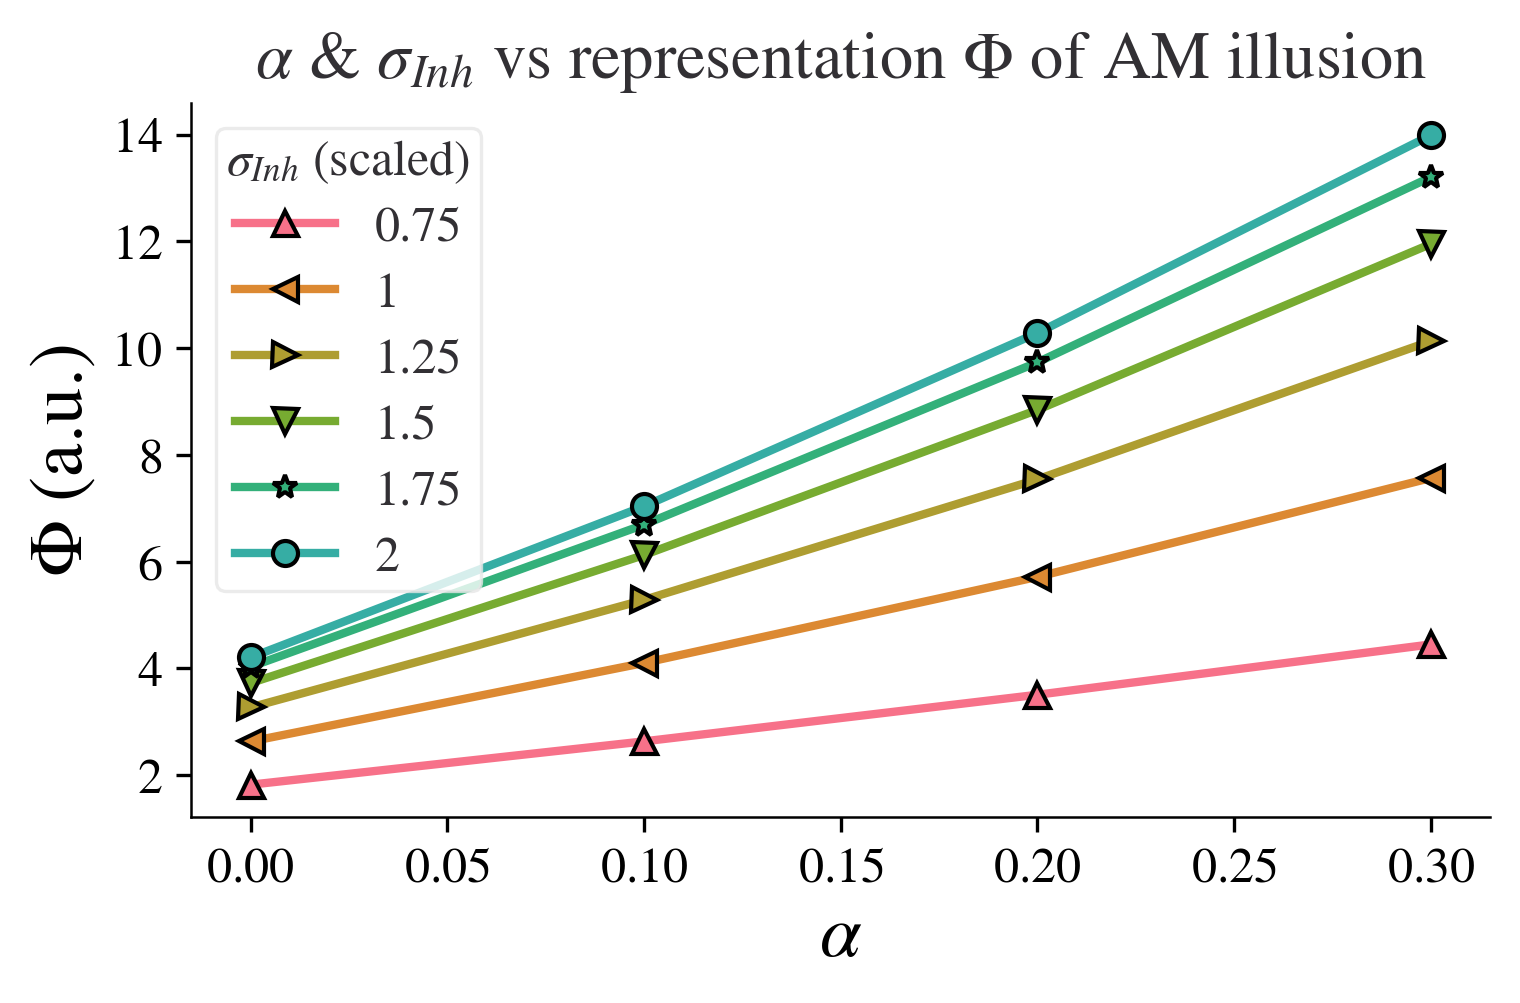

In [16]:
this_amp_list =[0.25,0.5,0.75,1,1.25,1.5,1.75,2]
pal=sns.color_palette("husl", 10)
plt.figure(figsize=(s1, s2))

len_j = len(this_alpha_list)

r_2d_wo_f = []
   
for i in range(1,len(this_amp_list)): 
    print(i)
    this_i_list = []
    for j in range(len(this_alpha_list)):
        this_i_list.append(np.max(np.array(inh_and_alpha_overlap_list)[i*len_j+j,:]))
    r_2d_wo_f.append(this_i_list)
    
for i in range(len(r_2d_wo_f[1:])):  

    plt.plot(this_alpha_list,np.array(r_2d_wo_f)[i+1,:],label=str(this_amp_list[i+1+1]),marker=marker_list[i])

plt.xlabel(r'$\alpha$')
plt.ylabel('$\Phi$ (a.u.)')
plt.legend(title=r"$\sigma_{Inh}$ (scaled)", loc='upper left',fontsize=12, title_fontsize=12)#, bbox_to_anchor=(1, 0.5))
plt.title(r'$\alpha$ & $\sigma_{Inh}$ vs representation $\Phi$ of AM illusion', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_al_inh_hi.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_al_inh_hi.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [17]:
A = 1
B = 115
C=20
#this_amp_inh=5.75

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale/1.5),dp*11*int(LGN_RF_scale/1.5),dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale/1.5)*unit_2_scale,dp*11*int(V1_RF_scale/1.5)*unit_2_scale,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = [0.003,0.002,0.001,0]


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]

pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()

combine_overlap_list =[]


this_amp_list =[0.25,0.5,0.75,1,1.25,1.5,1.75,2]


alpha_response_list = []
this_amp_exc= 2 /B 
this_amp_inh= 1 /C 
this_alpha=0.003*a_scale

for v1_inh_scale in tqdm(this_amp_list):
    for v1_exc_scale in tqdm(this_amp_list):
        v1_sigma_Ex_scale = v1_exc_scale  # *unit_2_scale
        v1_sigma_inh_scale = v1_inh_scale # * v1_amp_scale# *unit_2_scale

        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale
        this_v1_amp_exc = this_amp_exc*1 

        overlap = []

        for i in range(len(frequency_list)): 

            stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

            I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

            I.fill(trough)

            time_ed1 = time_st1 + stimulus_duration


            time_st2 = time_ed1 + stimulus_duration
            time_ed2 = time_st2 + stimulus_duration

            I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
            I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak



            X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )

            this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
            this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
            this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
            this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    
            a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
            b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

            response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
            response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]

            overlap.append(net.get_2response_pdf_v(response1,response2))

        combine_overlap_list.append(overlap)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 299/299 [00:00<00:00, 5031.38it/s]


100%|██████████| 299/299 [00:00<00:00, 4735.96it/s]


100%|██████████| 299/299 [00:00<00:00, 4759.92it/s]


100%|██████████| 299/299 [00:00<00:00, 4963.50it/s]


100%|██████████| 299/299 [00:00<00:00, 5100.48it/s]


100%|██████████| 299/299 [00:00<00:00, 5098.37it/s]


100%|██████████| 299/299 [00:00<00:00, 5049.84it/s]


100%|██████████| 299/299 [00:00<00:00, 4991.05it/s]


100%|██████████| 299/299 [00:00<00:00, 5018.03it/s]


100%|██████████| 299/299 [00:00<00:00, 5062.56it/s]


100%|██████████| 299/299 [00:00<00:00, 4991.17it/s]


100%|██████████| 299/299 [00:00<00:00, 5005.02it/s]


100%|██████████| 299/299 [00:00<00:00, 5139.68it/s]


100%|██████████| 299/299 [00:00<00:00, 5044.48it/s]


100%|██████████| 299/299 [00:00<00:00, 5003.70it/s]


100%|██████████| 299/299 [00:00<00:00, 4985.85it/s]


100%|██████████| 299/299 [00:00<00:00, 5036.21it/s]


100%|██████████| 299/299 [00:00<00:00, 5087

100%|██████████| 299/299 [00:00<00:00, 5112.61it/s]


100%|██████████| 299/299 [00:00<00:00, 5184.23it/s]


100%|██████████| 299/299 [00:00<00:00, 5006.75it/s]


100%|██████████| 299/299 [00:00<00:00, 4919.72it/s]


100%|██████████| 299/299 [00:00<00:00, 4200.79it/s]


100%|██████████| 299/299 [00:00<00:00, 5162.02it/s]


100%|██████████| 299/299 [00:00<00:00, 5078.57it/s]


100%|██████████| 299/299 [00:00<00:00, 4876.15it/s]


100%|██████████| 299/299 [00:00<00:00, 4708.30it/s]


100%|██████████| 299/299 [00:00<00:00, 4863.27it/s]


100%|██████████| 299/299 [00:00<00:00, 4952.64it/s]


100%|██████████| 299/299 [00:00<00:00, 4987.08it/s]


100%|██████████| 299/299 [00:00<00:00, 5020.83it/s]


100%|██████████| 299/299 [00:00<00:00, 4938.56it/s]


100%|██████████| 299/299 [00:00<00:00, 5042.69it/s]


100%|██████████| 299/299 [00:00<00:00, 4997.68it/s]


100%|██████████| 299/299 [00:00<00:00, 5103.49it/s]


100%|██████████| 299/299 [00:00<00:00, 5128.14it/s]


100%|██████████| 299/299 [00

100%|██████████| 299/299 [00:00<00:00, 5039.51it/s]


100%|██████████| 299/299 [00:00<00:00, 5085.70it/s]


100%|██████████| 299/299 [00:00<00:00, 5157.31it/s]


100%|██████████| 299/299 [00:00<00:00, 5110.75it/s]


100%|██████████| 299/299 [00:00<00:00, 5048.37it/s]


100%|██████████| 299/299 [00:00<00:00, 5083.32it/s]


100%|██████████| 299/299 [00:00<00:00, 5229.02it/s]


100%|██████████| 299/299 [00:00<00:00, 5077.44it/s]


100%|██████████| 299/299 [00:00<00:00, 5038.90it/s]


100%|██████████| 299/299 [00:00<00:00, 5080.46it/s]

 88%|████████▊ | 7/8 [00:18<00:02,  2.67s/it]

100%|██████████| 299/299 [00:00<00:00, 5130.68it/s]


100%|██████████| 299/299 [00:00<00:00, 5097.37it/s]


100%|██████████| 299/299 [00:00<00:00, 5049.74it/s]


100%|██████████| 299/299 [00:00<00:00, 5083.30it/s]


100%|██████████| 299/299 [00:00<00:00, 5121.02it/s]


100%|██████████| 299/299 [00:00<00:00, 5078.90it/s]


100%|██████████| 299/299 [00:00<00:00, 5005.12it/s]


100%|██████████| 299/299 [00:00<00:0

100%|██████████| 299/299 [00:00<00:00, 5118.64it/s]


100%|██████████| 299/299 [00:00<00:00, 5098.20it/s]


100%|██████████| 299/299 [00:00<00:00, 5037.67it/s]


100%|██████████| 299/299 [00:00<00:00, 5085.88it/s]


100%|██████████| 299/299 [00:00<00:00, 5132.78it/s]


100%|██████████| 299/299 [00:00<00:00, 5102.89it/s]


100%|██████████| 299/299 [00:00<00:00, 5033.84it/s]


100%|██████████| 299/299 [00:00<00:00, 5094.56it/s]


100%|██████████| 299/299 [00:00<00:00, 5167.48it/s]


100%|██████████| 299/299 [00:00<00:00, 5059.98it/s]


100%|██████████| 299/299 [00:00<00:00, 5058.88it/s]


100%|██████████| 299/299 [00:00<00:00, 5065.75it/s]


100%|██████████| 299/299 [00:00<00:00, 5141.32it/s]


100%|██████████| 299/299 [00:00<00:00, 5104.57it/s]


100%|██████████| 299/299 [00:00<00:00, 5047.54it/s]


100%|██████████| 299/299 [00:00<00:00, 5135.87it/s]


100%|██████████| 299/299 [00:00<00:00, 5177.26it/s]


100%|██████████| 299/299 [00:00<00:00, 5068.06it/s]


100%|██████████| 299/299 [00

100%|██████████| 299/299 [00:00<00:00, 5091.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5190.43it/s]


100%|██████████| 299/299 [00:00<00:00, 5092.49it/s]


100%|██████████| 299/299 [00:00<00:00, 5060.00it/s]


100%|██████████| 299/299 [00:00<00:00, 5168.81it/s]


100%|██████████| 299/299 [00:00<00:00, 5207.87it/s]


100%|██████████| 299/299 [00:00<00:00, 5153.85it/s]


100%|██████████| 299/299 [00:00<00:00, 5054.76it/s]


100%|██████████| 299/299 [00:00<00:00, 5141.34it/s]


100%|██████████| 299/299 [00:00<00:00, 5180.55it/s]


100%|██████████| 299/299 [00:00<00:00, 5154.55it/s]


100%|██████████| 299/299 [00:00<00:00, 5066.16it/s]


100%|██████████| 299/299 [00:00<00:00, 5128.92it/s]


100%|██████████| 299/299 [00:00<00:00, 5212.16it/s]


100%|██████████| 299/299 [00:00<00:00, 5127.41it/s]


100%|██████████| 299/299 [00:00<00:00, 5030.90it/s]


100%|██████████| 299/299 [00:00<00:00, 5098.39it/s]


100%|██████████| 299/299 [00:00<00:00, 5213.80it/s]


100%|██████████| 299/299 [00

100%|██████████| 299/299 [00:00<00:00, 5035.10it/s]


100%|██████████| 299/299 [00:00<00:00, 5165.06it/s]


100%|██████████| 299/299 [00:00<00:00, 5159.34it/s]


100%|██████████| 299/299 [00:00<00:00, 5077.93it/s]


100%|██████████| 299/299 [00:00<00:00, 5072.02it/s]


100%|██████████| 299/299 [00:00<00:00, 5126.61it/s]

 62%|██████▎   | 5/8 [00:13<00:08,  2.68s/it]

100%|██████████| 299/299 [00:00<00:00, 5139.57it/s]


100%|██████████| 299/299 [00:00<00:00, 5077.36it/s]


100%|██████████| 299/299 [00:00<00:00, 5062.56it/s]


100%|██████████| 299/299 [00:00<00:00, 5126.80it/s]


100%|██████████| 299/299 [00:00<00:00, 5205.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5150.46it/s]


100%|██████████| 299/299 [00:00<00:00, 5109.63it/s]


100%|██████████| 299/299 [00:00<00:00, 5130.57it/s]


100%|██████████| 299/299 [00:00<00:00, 5172.75it/s]


100%|██████████| 299/299 [00:00<00:00, 5152.16it/s]


100%|██████████| 299/299 [00:00<00:00, 5097.00it/s]


100%|██████████| 299/299 [00:00<00:0

100%|██████████| 299/299 [00:00<00:00, 5141.01it/s]


100%|██████████| 299/299 [00:00<00:00, 5122.15it/s]


100%|██████████| 299/299 [00:00<00:00, 5012.66it/s]


100%|██████████| 299/299 [00:00<00:00, 5110.67it/s]


100%|██████████| 299/299 [00:00<00:00, 5213.24it/s]


100%|██████████| 299/299 [00:00<00:00, 5131.04it/s]


100%|██████████| 299/299 [00:00<00:00, 5071.22it/s]


100%|██████████| 299/299 [00:00<00:00, 5114.78it/s]


100%|██████████| 299/299 [00:00<00:00, 5240.38it/s]


100%|██████████| 299/299 [00:00<00:00, 5157.31it/s]


100%|██████████| 299/299 [00:00<00:00, 5038.09it/s]


100%|██████████| 299/299 [00:00<00:00, 5146.22it/s]


100%|██████████| 299/299 [00:00<00:00, 5196.41it/s]


100%|██████████| 299/299 [00:00<00:00, 5115.65it/s]


100%|██████████| 299/299 [00:00<00:00, 5061.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5112.42it/s]


100%|██████████| 299/299 [00:00<00:00, 5218.23it/s]


100%|██████████| 299/299 [00:00<00:00, 5128.64it/s]


100%|██████████| 299/299 [00

100%|██████████| 299/299 [00:00<00:00, 5086.31it/s]


100%|██████████| 299/299 [00:00<00:00, 5057.76it/s]


100%|██████████| 299/299 [00:00<00:00, 5099.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 299/299 [00:00<00:00, 4963.50it/s]


100%|██████████| 299/299 [00:00<00:00, 5110.59it/s]


100%|██████████| 299/299 [00:00<00:00, 5033.60it/s]


100%|██████████| 299/299 [00:00<00:00, 5116.28it/s]


100%|██████████| 299/299 [00:00<00:00, 5205.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5143.28it/s]


100%|██████████| 299/299 [00:00<00:00, 5058.88it/s]


100%|██████████| 299/299 [00:00<00:00, 5092.03it/s]


100%|██████████| 299/299 [00:00<00:00, 5163.27it/s]


100%|██████████| 299/299 [00:00<00:00, 5169.55it/s]


100%|██████████| 299/299 [00:00<00:00, 5099.26it/s]


100%|██████████| 299/299 [00:00<00:00, 5118.45it/s]


100%|██████████| 299/299 [00:00<00:00, 5212.07it/s]


100%|██████████| 299/299 [00:00<00:00, 5071.67it/s]


100%|██████████| 299/299 [00:00<00:00, 5053.

100%|██████████| 299/299 [00:00<00:00, 5330.80it/s]


100%|██████████| 299/299 [00:00<00:00, 5423.94it/s]


100%|██████████| 299/299 [00:00<00:00, 5362.94it/s]


100%|██████████| 299/299 [00:00<00:00, 5268.32it/s]


100%|██████████| 299/299 [00:00<00:00, 5345.50it/s]


100%|██████████| 299/299 [00:00<00:00, 5197.27it/s]


100%|██████████| 299/299 [00:00<00:00, 5327.20it/s]


100%|██████████| 299/299 [00:00<00:00, 5318.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5350.77it/s]


100%|██████████| 299/299 [00:00<00:00, 5443.27it/s]


100%|██████████| 299/299 [00:00<00:00, 5373.63it/s]


100%|██████████| 299/299 [00:00<00:00, 5305.56it/s]


100%|██████████| 299/299 [00:00<00:00, 5330.41it/s]


100%|██████████| 299/299 [00:00<00:00, 5423.17it/s]


100%|██████████| 299/299 [00:00<00:00, 5358.82it/s]


100%|██████████| 299/299 [00:00<00:00, 5322.83it/s]


100%|██████████| 299/299 [00:00<00:00, 5371.49it/s]


100%|██████████| 299/299 [00:00<00:00, 5445.97it/s]


100%|██████████| 299/299 [00

100%|██████████| 299/299 [00:00<00:00, 5224.08it/s]


100%|██████████| 299/299 [00:00<00:00, 5250.87it/s]


100%|██████████| 299/299 [00:00<00:00, 5439.82it/s]


100%|██████████| 299/299 [00:00<00:00, 5371.99it/s]


100%|██████████| 299/299 [00:00<00:00, 5303.30it/s]


100%|██████████| 299/299 [00:00<00:00, 5310.84it/s]


100%|██████████| 299/299 [00:00<00:00, 5412.75it/s]


100%|██████████| 299/299 [00:00<00:00, 5306.89it/s]


100%|██████████| 299/299 [00:00<00:00, 5296.64it/s]


100%|██████████| 299/299 [00:00<00:00, 5343.97it/s]


100%|██████████| 299/299 [00:00<00:00, 5454.61it/s]


100%|██████████| 299/299 [00:00<00:00, 5356.80it/s]


100%|██████████| 299/299 [00:00<00:00, 5292.98it/s]


100%|██████████| 299/299 [00:00<00:00, 5379.23it/s]

 88%|████████▊ | 7/8 [00:17<00:02,  2.55s/it]

100%|██████████| 299/299 [00:00<00:00, 5374.59it/s]


100%|██████████| 299/299 [00:00<00:00, 5299.08it/s]


100%|██████████| 299/299 [00:00<00:00, 5131.54it/s]


100%|██████████| 299/299 [00:00<00:0

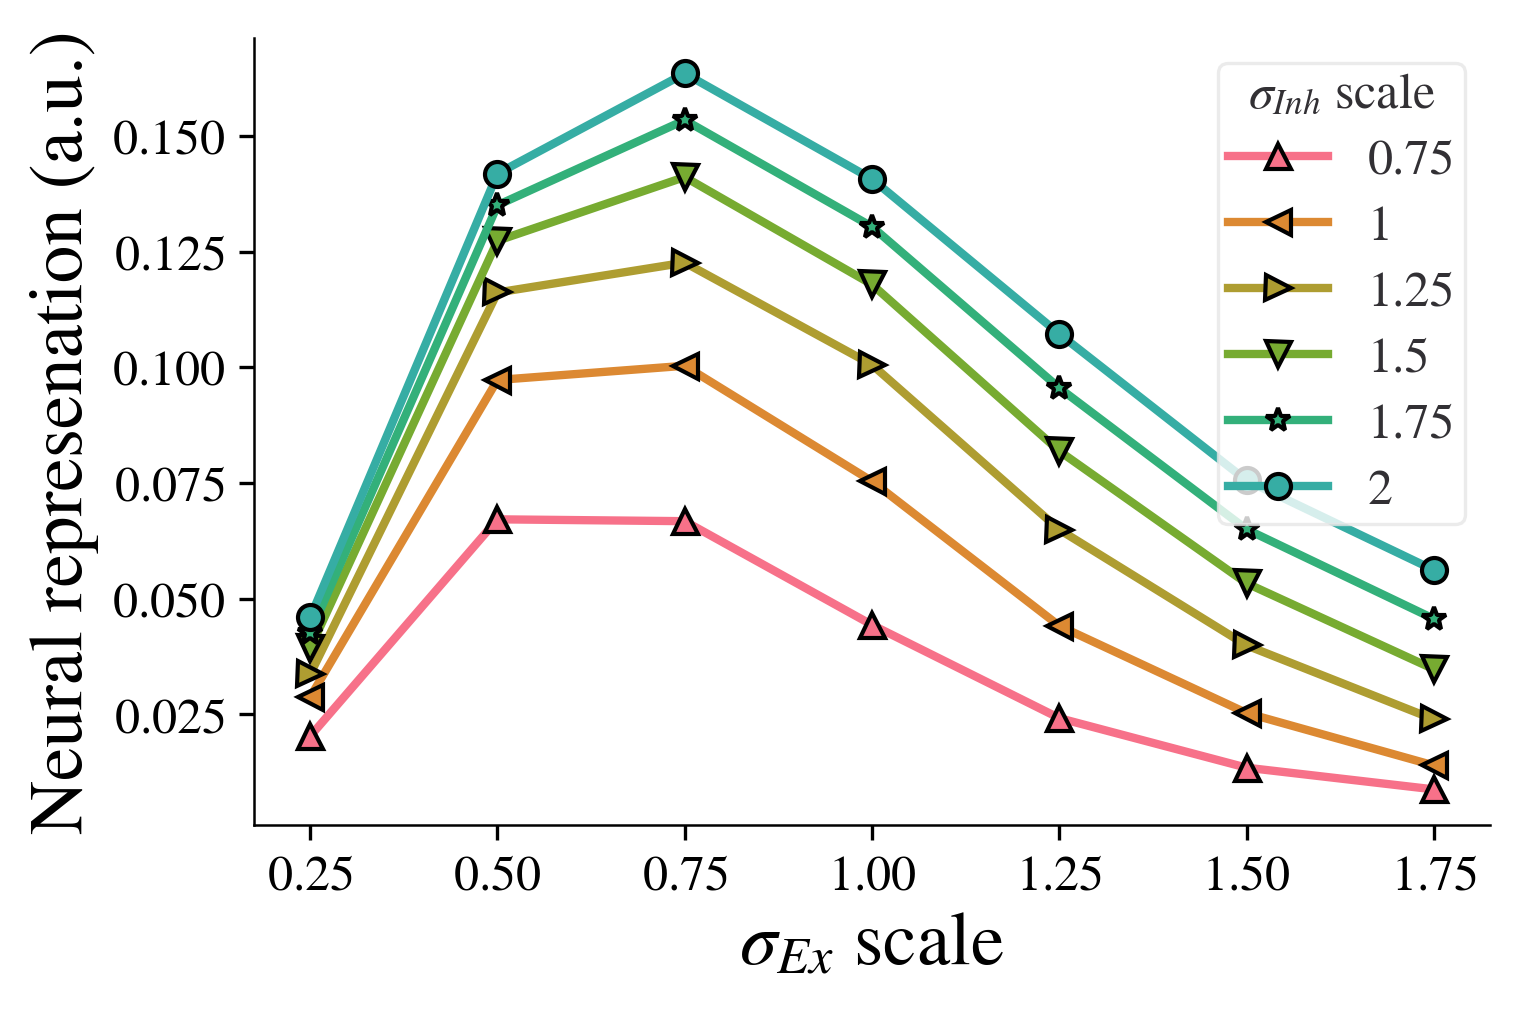

In [18]:
this_amp_list =[0.25,0.5,0.75,1,1.25,1.5,1.75,2]
pal=sns.color_palette("husl", 10)

a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)

len_j = len(this_amp_list)

r_2d_wo_f = []
plt.figure(figsize=(s1, s2))


for i in range(2,len(this_amp_list)):   

    this_i_list = []
    for j in range(len(this_amp_list)-1):
        this_i_list.append(np.max(np.array(combine_overlap_list)[i*len_j+j]))
    r_2d_wo_f.append(this_i_list)
    
for i in range(len(this_amp_list)-2):                           
    plt.plot(this_amp_list[:-1],np.array(r_2d_wo_f)[i]/y_scale,label=str(this_amp_list[i+2]),marker=marker_list[i])
  
    
plt.xlabel(r'$\sigma_{Ex}$ scale')
plt.ylabel('Neural represenation (a.u.)')
plt.legend(title=r"$\sigma_{Inh}$ scale", loc='upper right',fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_sig_combine.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_sig_combine.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)




In [19]:
A = 1
B = 115
C=20
this_amp_exc=2/B 
this_amp_inh=1/C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 


timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size



plt.figure(figsize=(4, 3))


this_alpha_list = [0.003,0.002,0.001,0]


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]

pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()




inh_amp_overlap_list =[]



this_amp_list =[0.75,1,1.25,1.5,1.75]


alpha_response_list = []
this_alpha=0.003*10

for v1_amp_scale in tqdm(this_amp_list):
    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 # v1_amp_scale# *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale


    overlap = []

    for i in range(len(frequency_list)): 

        stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

        I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

        I.fill(trough)

        time_ed1 = time_st1 + stimulus_duration


        time_st2 = time_ed1 + stimulus_duration
        time_ed2 = time_st2 + stimulus_duration

        I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
        I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak



        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                        filter_unit, filter_unit_2, dt,
                                                                        timestep, pixel_size, boundary_size,
                                                                        this_alpha=this_alpha,
                                                                        this_amp_inh=this_amp_inh,
                                                                        this_amp_exc=this_amp_exc,
                                                                        v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                        v1_sigma_inh=this_v1_sigma_inh, 
                                                                        v1_amp_inh=this_v1_amp_inh, 
                                                                        LGN_RF_scale=LGN_RF_scale,
                                                                        V1_RF_scale=V1_RF_scale, 
                                                                        v1_amp_exc=this_amp_exc  )

        this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)

        a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
        b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

        response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
        response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]

        overlap.append(net.get_2response_pdf_v(response1,response2))

    inh_amp_overlap_list.append(overlap)





100%|██████████| 299/299 [00:00<00:00, 5416.68it/s]

100%|██████████| 299/299 [00:00<00:00, 5128.62it/s]

100%|██████████| 299/299 [00:00<00:00, 5278.96it/s]

100%|██████████| 299/299 [00:00<00:00, 5122.34it/s]

100%|██████████| 299/299 [00:00<00:00, 5443.67it/s]

100%|██████████| 299/299 [00:00<00:00, 5134.52it/s]

100%|██████████| 299/299 [00:00<00:00, 5293.92it/s]

100%|██████████| 299/299 [00:00<00:00, 5113.13it/s]

100%|██████████| 299/299 [00:00<00:00, 5451.60it/s]

100%|██████████| 299/299 [00:00<00:00, 5122.30it/s]

100%|██████████| 299/299 [00:00<00:00, 5309.31it/s]

100%|██████████| 299/299 [00:00<00:00, 5127.24it/s]

100%|██████████| 299/299 [00:00<00:00, 5454.21it/s]

100%|██████████| 299/299 [00:00<00:00, 5092.41it/s]

100%|██████████| 299/299 [00:00<00:00, 5302.91it/s]

100%|██████████| 299/299 [00:00<00:00, 5104.32it/s]

100%|██████████| 299/299 [00:00<00:00, 5435.77it/s]

100%|██████████| 299/299 [00:00<00:00, 5137.89it/s]

100%|██████████| 299/299 [00:00<00:00, 5288.36

<Figure size 1200x900 with 0 Axes>

# Figure 6D,6C

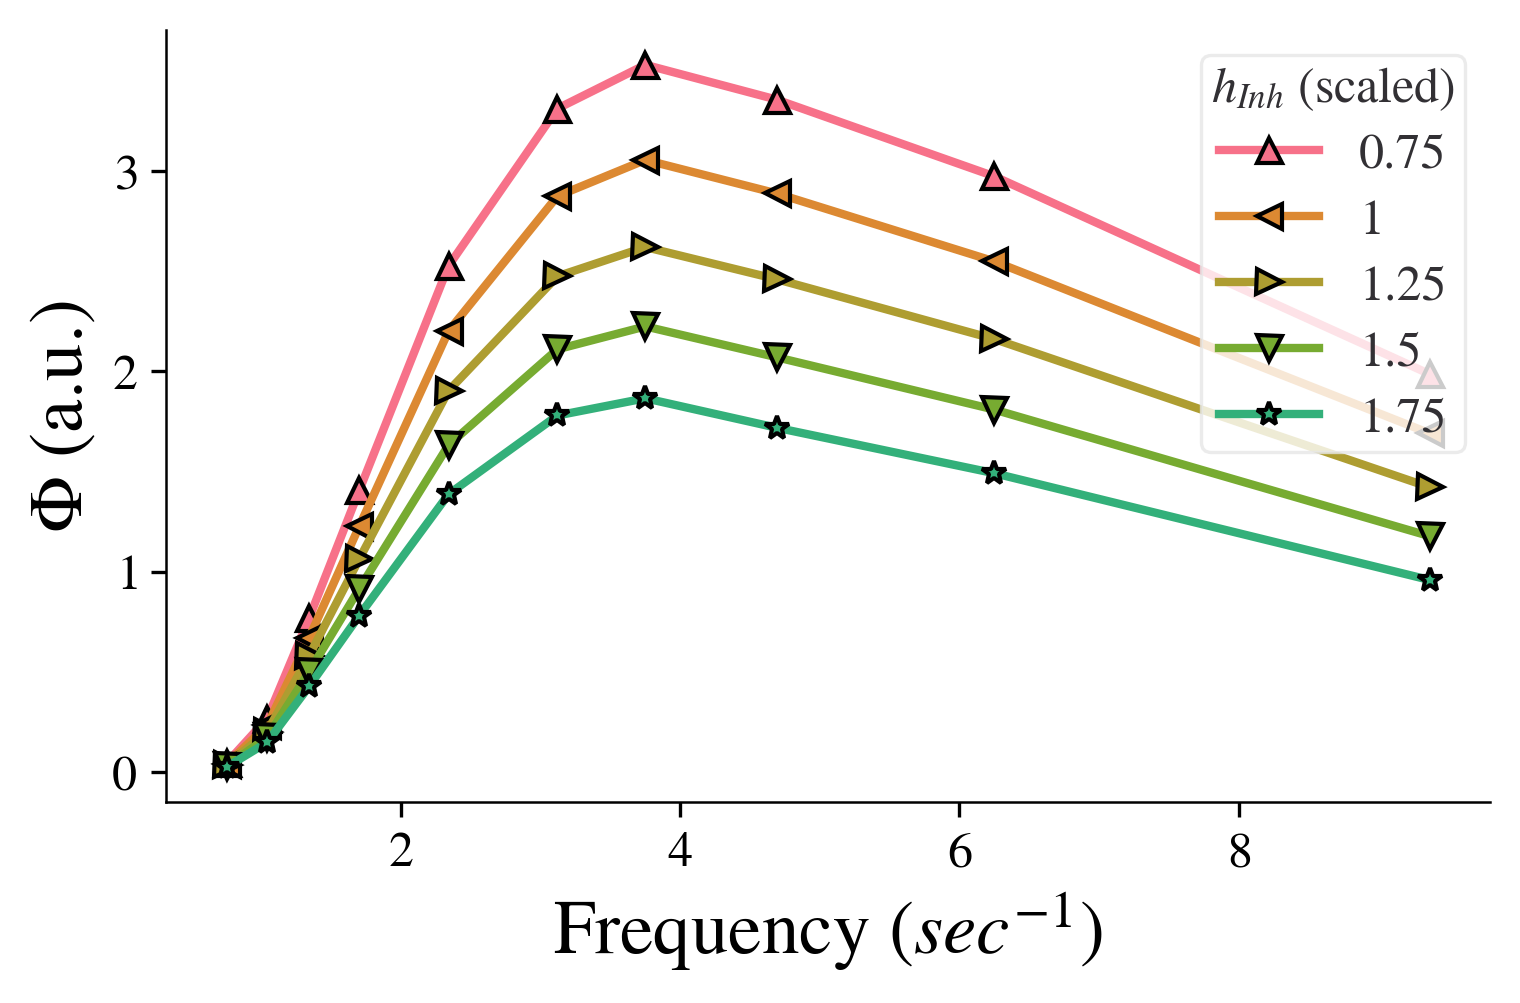

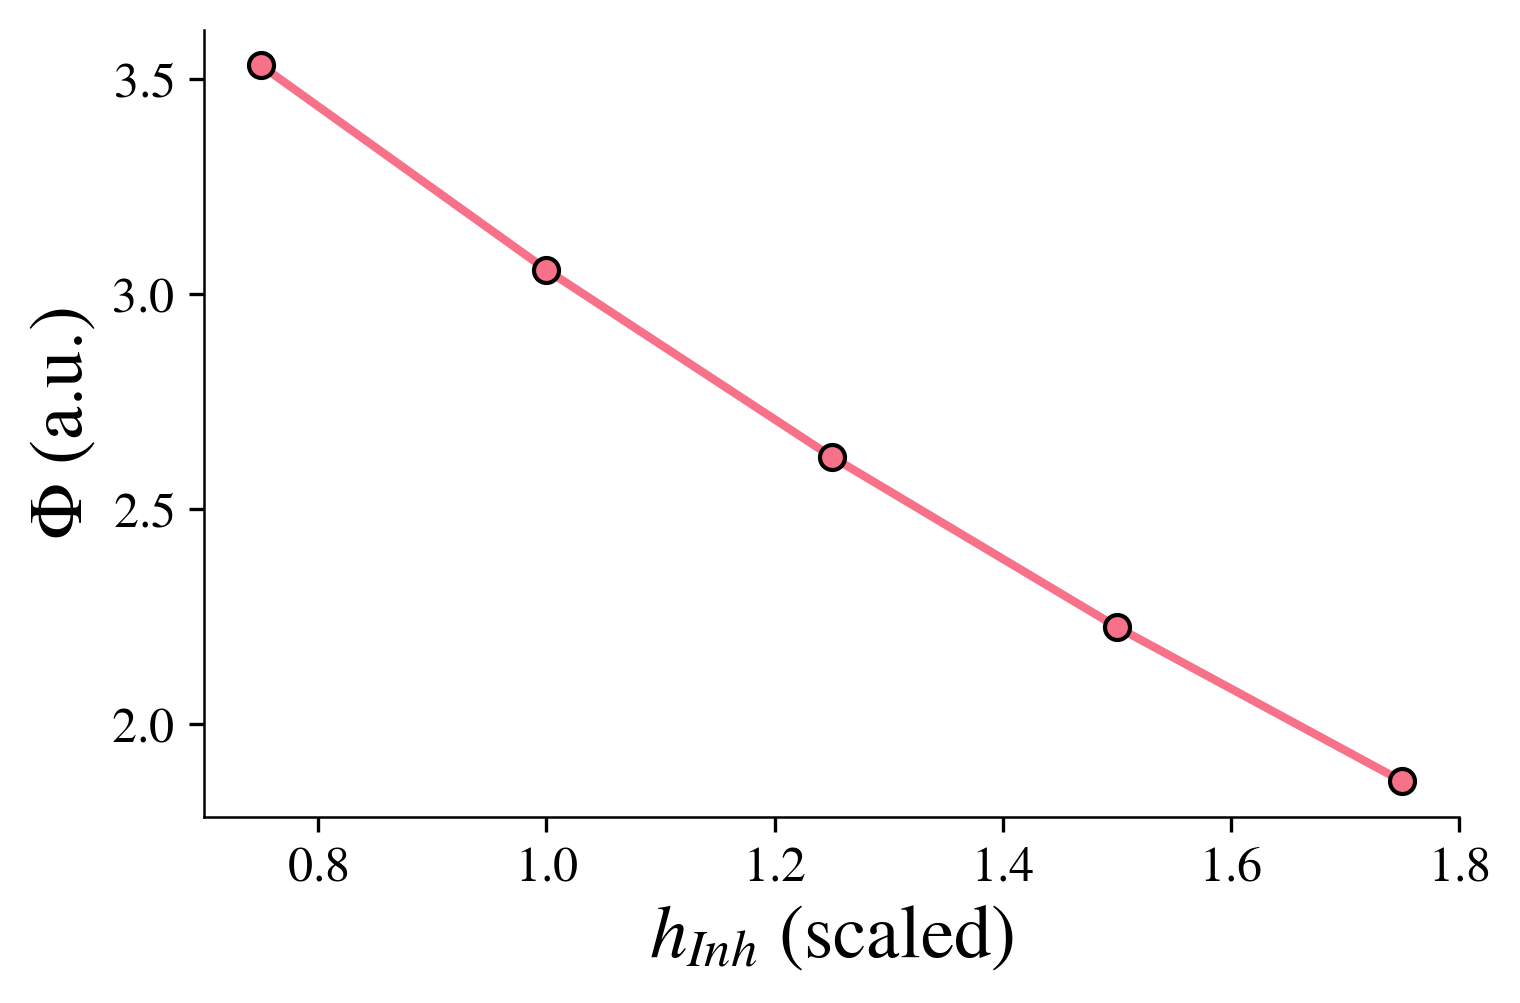

In [20]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',prop_cycle= colors)

this_amp_list =[0.75,1,1.25,1.5,1.75]

plt.figure(figsize=(s1, s2))
inh_overlap_list = np.array(inh_amp_overlap_list)
for i in range(len(inh_amp_overlap_list)):
    plt.plot(frequency_list,np.squeeze(inh_amp_overlap_list[i]),marker=marker_list[i],label=str(this_amp_list[i]))
plt.xlabel(r'Frequency $(sec^{-1})$')
plt.ylabel("$\Phi$ (a.u.)")
plt.legend(title=r'$h_{Inh}$ (scaled)', loc='upper right',fontsize=12, title_fontsize=12), #bbox_to_anchor=(1, 0.45))

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_inh_amp_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_inh_amp_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


plt.figure(figsize=(s1, s2))
max_overlap_list =[]

for i in range(len(inh_amp_overlap_list)):
    max_overlap_list.append(np.max((inh_amp_overlap_list[i])))
plt.plot(this_amp_list, np.array(max_overlap_list),marker='o')
plt.xlabel(r'$h_{Inh}$ (scaled)')
plt.ylabel("$\Phi$ (a.u.)")

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_inh_amp_hi_plot.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_inh_amp_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)







